## Prepare Notebook

In [1]:
import jax.numpy as jnp
import jax.random as jr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sts_jax.structural_time_series as sts


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
key = jr.PRNGKey(0)

## Read Data

In [3]:
df = pd.read_csv("../data/sts_sample_data.csv", parse_dates=["date"])

df.head()

,date,y,x,day_of_month,month,day_of_week,daysinmonth
0,2017-01-01,3.568240,0.00000,1,1,6,31
1,2017-01-02,5.201631,0.00000,2,1,0,31
2,2017-01-03,5.643587,0.00000,3,1,1,31
3,2017-01-04,11.252480,0.99181,4,1,2,31
4,2017-01-05,3.798210,0.00000,5,1,3,31


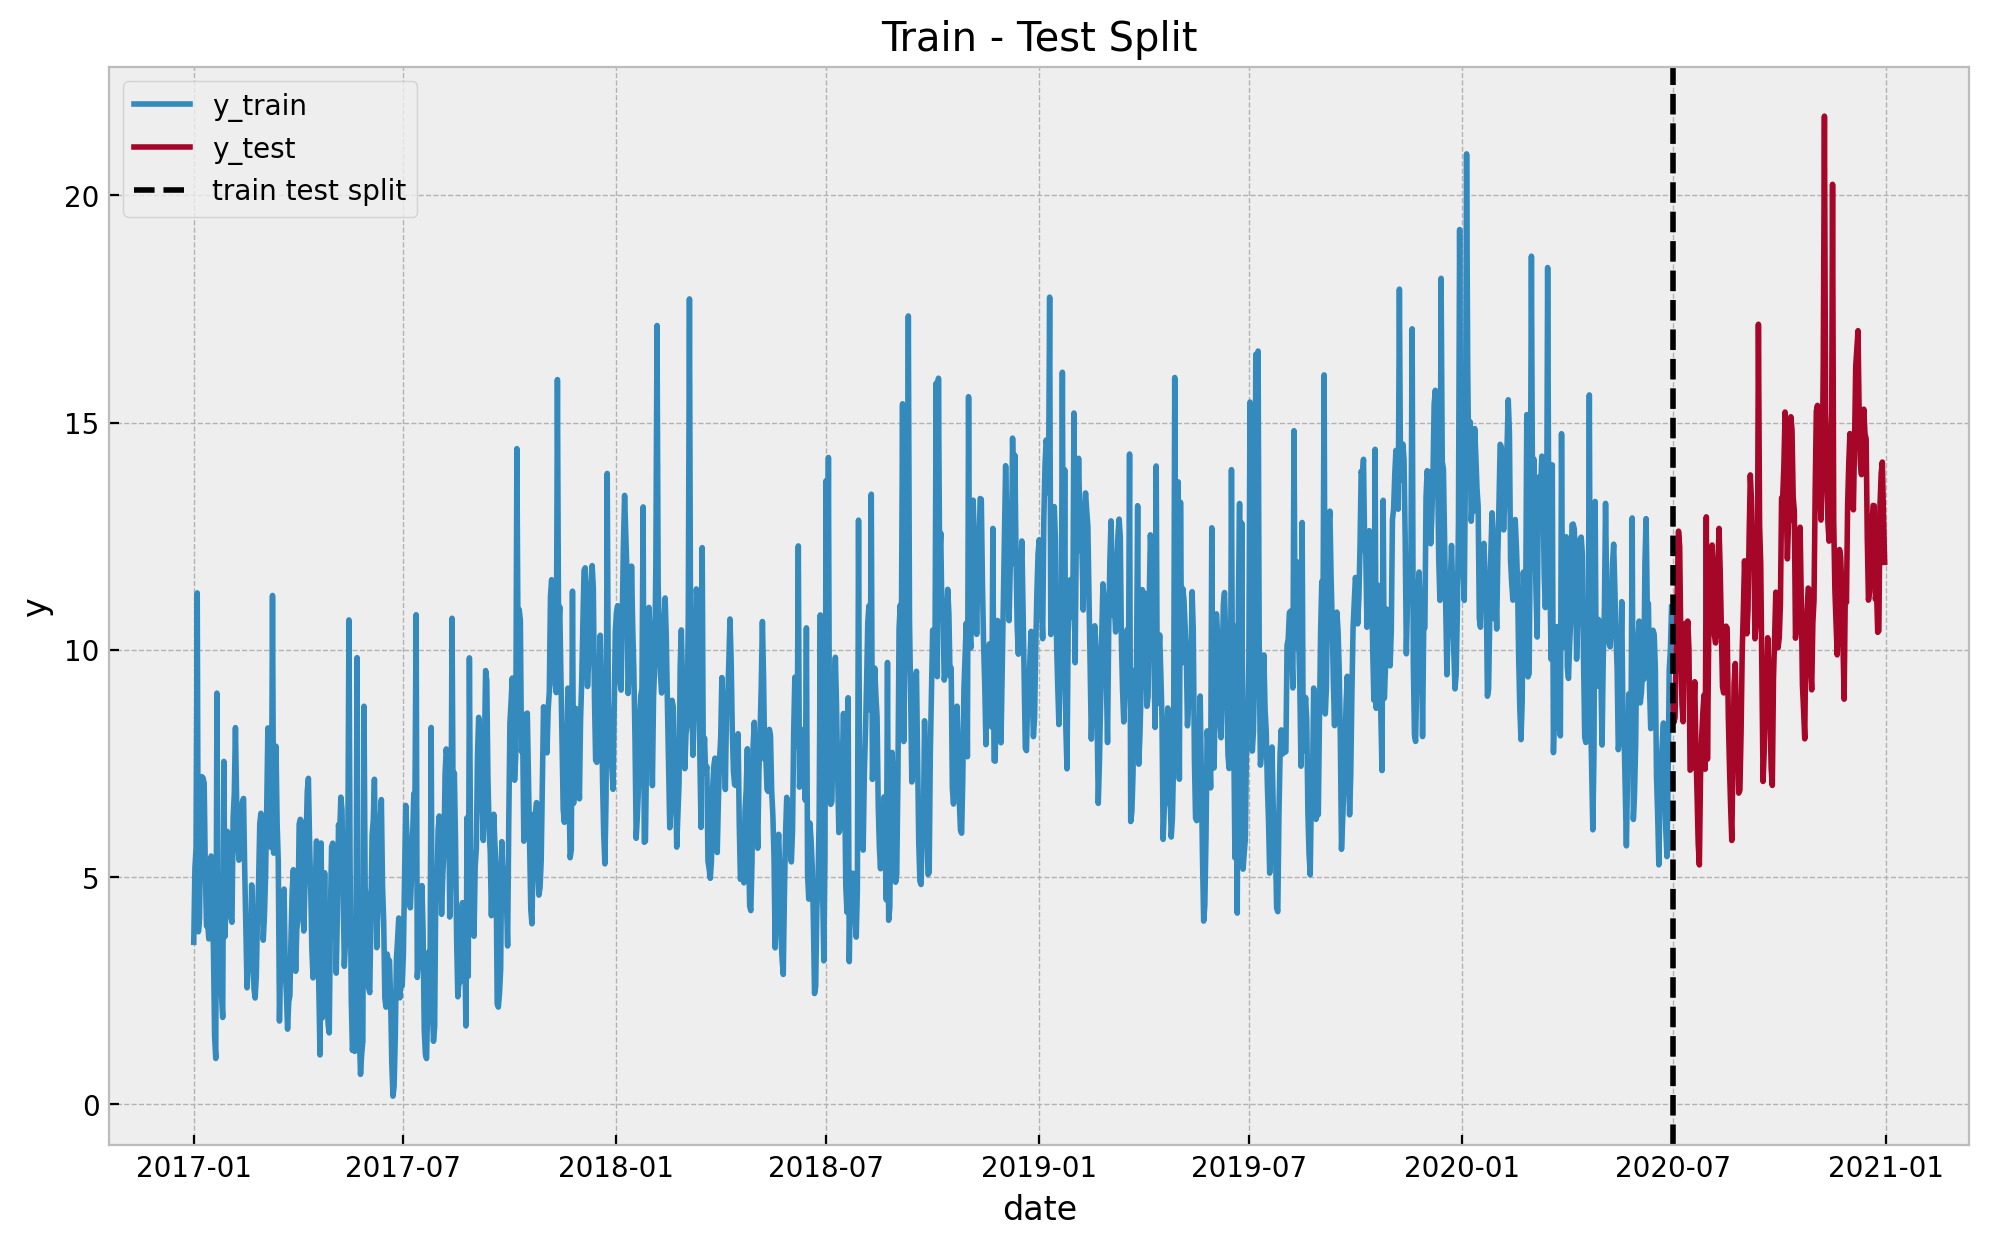

In [4]:
threshold_date = pd.to_datetime("2020-07-01")
mask = "date < @threshold_date"

df_train = df.query(mask)
df_test = df.query(f"~ ({mask})")

n_test = df_test.shape[0]

fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", label="y_train", data=df_train, color="C0", ax=ax)
sns.lineplot(x="date", y="y", label="y_test", data=df_test, color="C1", ax=ax)
ax.axvline(threshold_date, color="black", linestyle="--", label="train test split")
ax.legend(loc="upper left")
ax.set(title="Train - Test Split");

## Model Specification

In [5]:
x_train = jnp.array(df_train["x"].to_numpy()[:, None])
x_test = jnp.array(df_test["x"].to_numpy()[:, None])
y_train = jnp.array(df_train["y"].to_numpy()[:, None])
y_test = jnp.array(df_test["y"].to_numpy()[:, None])

In [6]:
model = sts.StructuralTimeSeries(
    obs_time_series=y_train,
    components=[
        sts.LocalLinearTrend(name="local_linear_trend"),
        sts.SeasonalTrig(
            name="yearly_seasonality", num_seasons=12, num_steps_per_season=30
        ),
        sts.SeasonalTrig(
            name="monthly_seasonality", num_seasons=30, num_steps_per_season=1
        ),
        sts.SeasonalDummy(
            name="weekly_seasonality", num_seasons=7, num_steps_per_season=1
        ),
        sts.LinearRegression(
            name="x_exog", dim_covariates=1, add_bias=True,
        )
    ],
    covariates=x_train,
    obs_distribution="Gaussian",
)

In [8]:
# Fit the model with MLE estimator
mle_optimal_params, mle_losses = model.fit_mle(
    obs_time_series=y_train, covariates=x_train, key=key
)

In [10]:
# Fit with HMC (NUTS), initialized by MLE estimation.
nuts_param_samps, nuts_param_log_probs = model.fit_hmc(
    obs_time_series=y_train,
    covariates=x_train,
    num_samples=100,
    initial_params=mle_optimal_params,
)

Running window adaptation


In [15]:
x_test

Array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.952815  ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.   

In [17]:
forecast_means, forecast_obs = model.forecast(
    obs_time_series=y_train,
    sts_params=nuts_param_samps,
    num_forecast_steps=n_test,
    past_covariates=x_train,
    forecast_covariates=x_test,
)

<AxesSubplot:xlabel='date', ylabel='y'>

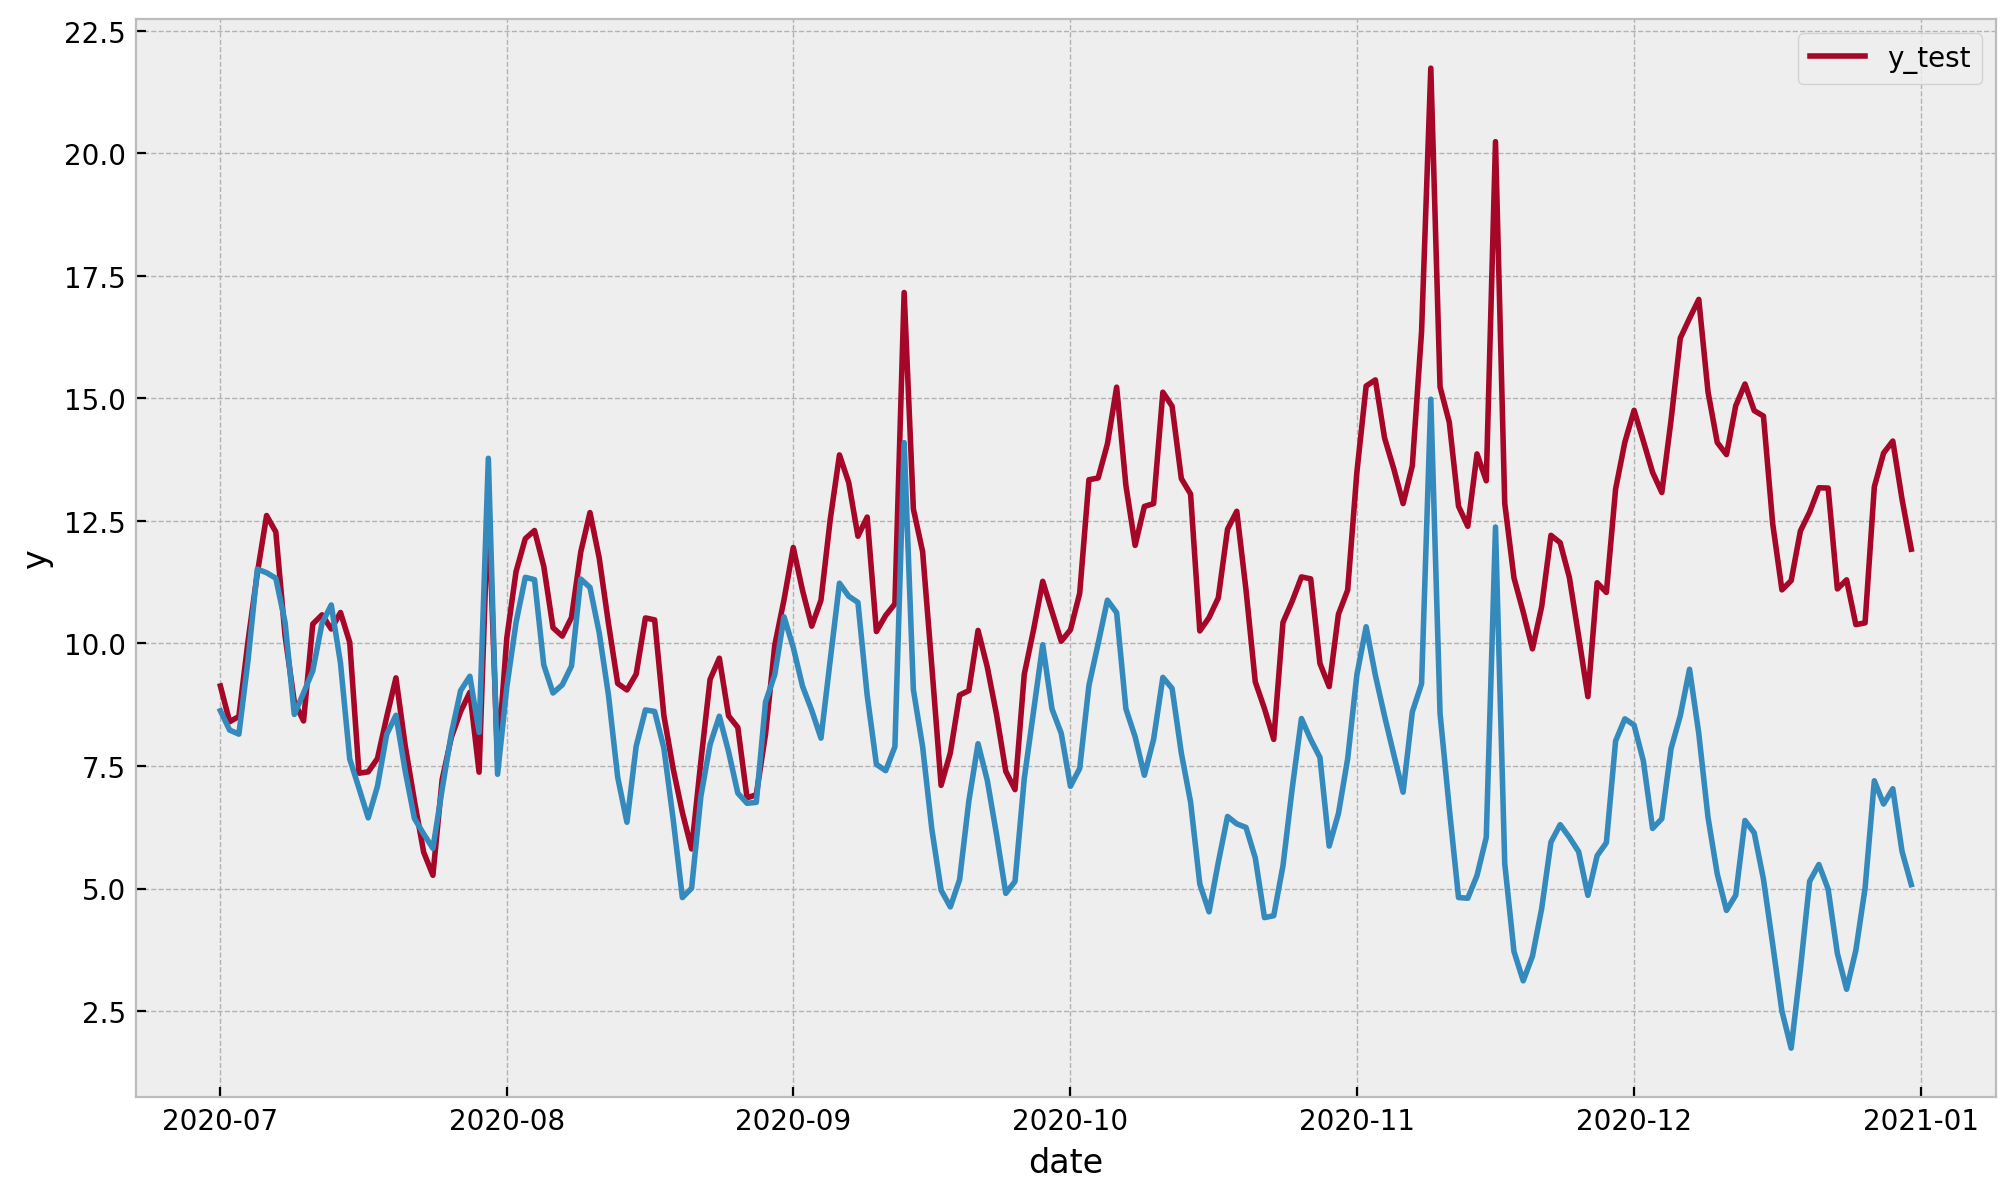

In [18]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", label="y_test", data=df_test, color="C1", ax=ax)
sns.lineplot(
    x=df_test["date"],
    y=jnp.concatenate(forecast_means, axis=0).squeeze().mean(axis=0),
    ax=ax,
)